In [396]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# The Data
The data consists of cancer signal magnitudes at 52 genomic locations for 64 patients.  
Patients 34-45 are afflicted with disease A.  
Patients 55-62 are afflicted with disease B.  

**Goal:** The goal of this project is to find genomic locations, such that when the signals are summed up, result in patients 34-45 ranked within the top 12, followed by patients 55-62 in the top 20, followed by the rest of the patients.

The default score is the result from summing all the locations and ranking the patients based on this. Your performance will be measured by how much you beat this method in rankings. The more packed you can get the disease patients into the higher rankings, the better. It is better to have 10 of the dieased patients within the top 12 than to have the 12 disease patients spread out over the top 20.  

Some locations probably don't progress you towards your goal in any way. If this is the case, you can always remove them.  
Trying out every possible location and checking for the best rankings will provide you the best solution, but it isn't viable because the time complexity is 2^n. On larger datasets, this would be impossible to calculate.  

**Output:**
1. A set of locations you found that achieved the best ranking
2. The ranking of all patients based on this set of locations
3. A detailed description on how you reached your results  

**Note:**  If you have multiple methods or rankings you discovered, then feel free to list them all. If you also attempted a method but found that it did not achieve what you wanted, you should include this as well. This will only help your score and won't negatively affect it in any.  

In [397]:
raw = pd.read_excel('QGtest.xlsx', index_col=0, header=None).T

##### Labelling Patients
Patients with disease A are labelled A and 0  
Patients with disease B are labelled B and 1  
Patients with no disease are labelled N and 2

In [398]:
df = raw.reset_index().drop(columns='index').rename(index=str, columns={'Locations':'Patient'})
df['Disease'], df['nDisease'] = 'N', 2
df['Disease'][34:46], df['nDisease'][34:46] = 'A', 0
df['Disease'][55:63], df['nDisease'][55:63] = 'B', 1
df.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Patient,Location 0,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6,Location 7,Location 8,Location 9,Location 10,Location 11,Location 12,Location 13,Location 14,Location 15,Location 16,Location 17,Location 18,Location 19,Location 20,Location 21,Location 22,Location 23,Location 24,Location 25,Location 26,Location 27,Location 28,Location 29,Location 30,Location 31,Location 32,Location 33,Location 34,Location 35,Location 36,Location 37,Location 38,Location 39,Location 40,Location 41,Location 42,Location 43,Location 44,Location 45,Location 46,Location 47,Location 48,Location 49,Location 50,Location 51,Location 52,Disease,nDisease
0,Patient 0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,N,2
1,Patient 1,0,0,0,0,1,1,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,2,0,2,1,0,0,0,N,2
2,Patient 2,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,N,2
3,Patient 3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,3,0,1,0,0,2,1,2,2,0,0,0,N,2
4,Patient 4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,2,1,0,1,1,1,1,N,2


In [399]:
#Change data type from str to numeric
numericcolumns = list(df.columns)
numericcolumns.remove('Patient')
numericcolumns.remove('Disease')
numericcolumns.remove('nDisease')
df[numericcolumns] = df[numericcolumns].apply(pd.to_numeric)

### Plotting Mean Signals
I want to plot the mean signals for all patients to get an idea of how signals at each location correlates with disease A or B. Disease A is represented in red, B in blue, and Negative for both diseases in black.

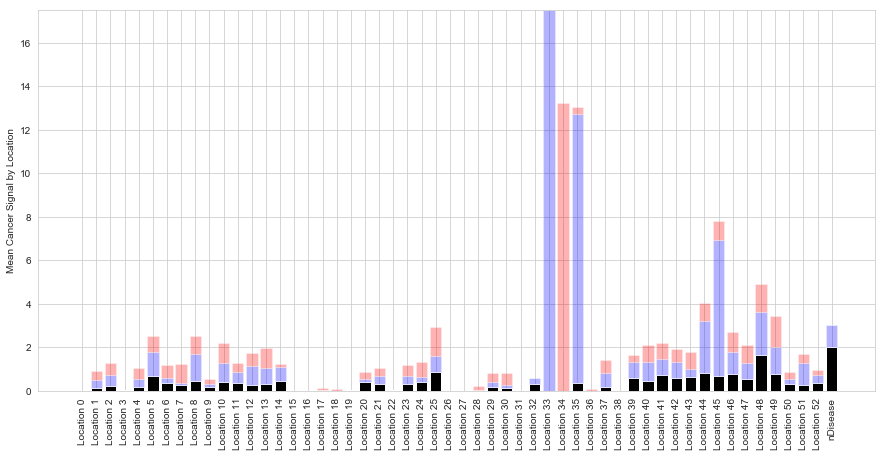

In [400]:
#Average signals for each group
Meansignals = df.groupby('Disease', as_index=False).agg(np.mean)
#Plot of the mean signal of each location for Disease A, B and No disease.
Alabels = list(Meansignals[Meansignals.Disease=='A'].columns[1:])
Avalues = Meansignals[Meansignals.Disease=='A'].iloc[0,1:]
Blabels = list(Meansignals[Meansignals.Disease=='B'].columns[1:])
Bvalues = Meansignals[Meansignals.Disease=='B'].iloc[0,1:]
Nlabels = list(Meansignals[Meansignals.Disease=='N'].columns[1:])
Nvalues = Meansignals[Meansignals.Disease=='N'].iloc[0,1:]
#Stacked plot of Location signals
plt.figure(figsize=(15,7))
plt.bar(x=Nlabels, height=Nvalues, color='k')
plt.bar(x=Blabels, height=Bvalues, bottom=Nvalues, color='b', alpha=.3)
plt.bar(x=Alabels, height=Avalues, bottom=Bvalues+Nvalues, color='r', alpha=.3)
plt.xticks(rotation=90)
plt.ylabel('Mean Cancer Signal by Location')
plt.show()

##### Removing Redundant Locations
I notice some locations have no signals for any of the three groups we are looking at. These locations are unhelpful in seperating the three classes as they will not contribute to the sum rankings. Below, I remove these signals to decrease the feature space.

In [401]:
#Remove locations that have 0 cancer signals for all patients.
SignallessLocations = ['Location 0', 'Location 15', 'Location 16', 
                     'Location 26', 'Location 27', 'Location 31', 'Location 38']
numericcolumns = [item for item in numericcolumns if item not in SignallessLocations]

##### Correlation Map
The human genome consists of relationships and interactions between genes at different locations. I am curious to see if there will be any correlations between signal magnitudes at multiple locations.

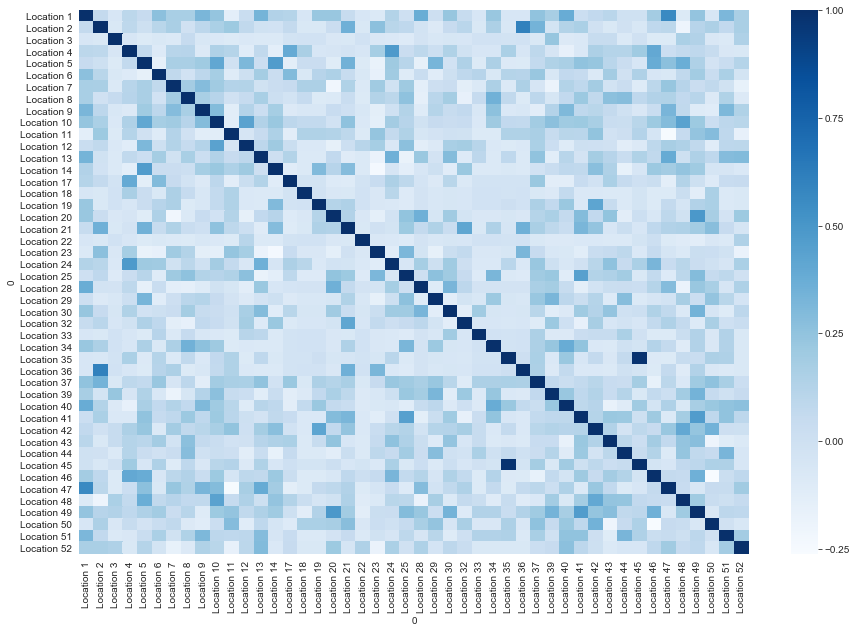

In [402]:
#Correlation table of each location.
plt.figure(figsize=(15,10))
sns.heatmap(df[numericcolumns].corr(), cmap='Blues')
plt.show()

# Logistic Regression and Support Vector Machines
I plan to train a logistic regression model on the dataset. The coefficients from the trained model can be used to describe how the contribution of a specific location in predicting a specific class. We can then take the coefficients with the highest magnitudes to identify locations that are stark predictors of one class.
**Notes:** Unfortunately, because the sample size is so small, I expect heavy overfitting that will generate questionable results.

**Heuristic:** We can measure the distance between vectors of the ideal ranking to the vector obtained from using a certain range of coefficients (from most positive to 0). We can then find the range that minimizes the distance.  
For example:  
A: 0  
B: 1  
N: 2  
The ideal vector would be: [0] *12 + [1] *8 + [2] *44   
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

**First Approach: Combining Classes A and B**
The instructions say that disease A and B are similar. As an initial approach, I want to combine diseases A and B in order to see if patients who are negative are easier to seperate out. The weights will also be more descriptive in a binary example.

**Analysis of Feature Weights**
The main challenge that persists through this project is the incredibly small sample size and relatively large number of features that often contribute to multiple classes. However, we can use the weights of the logistic regression model to explain which features contributed the most to each class.  
**Create DataFrame of Signal Sums**
I want to create a dataframe consisting of the ranked signal sums for locations that have positive weights (weights that contributed greatly to the positive class. I'm still working on how I want to resolve ties.

In [333]:
print([0] *12 + [1] *8 + [2] *44)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [334]:
#Train log model that returns sorted weights that we can use to find locations
def log_model(mtype, features, labels):
    scaler = StandardScaler()
    ScaledSignals = scaler.fit_transform(features)
    
    X = ScaledSignals
    Y = labels
    if mtype == 'log':
        model = LogisticRegression(penalty = 'l2', C=10, fit_intercept=True, solver='lbfgs')
    elif mtype == 'svc':
        model = LinearSVC(penalty='l2', loss='hinge', C=10, fit_intercept=False, dual=True, max_iter=100000)
    model.fit(X,Y)
    prediction = model.predict(X)
    print('Classification Report\n\n', classification_report(Y, prediction))
    print(cross_val_score(model,X, Y,cv=5))
    
    weights = pd.DataFrame({'Locations':numericcolumns, 
                            'weights':model.coef_[0]}).sort_values(by='weights', ascending=False)
    return weights


#Not sure how I'm going to break ties yet, right now Im getting better scores by pushing A and B up.
#This function iterates through the weights and finds a range of locations that minimizes the distance between the
#resultant rankings and the ideal rankings
def get_locations(weights, metric): 
    distance = 0
    locationrange = 0
    rankings = 0
    locationlist = weights['Locations'].tolist()
    bestrank = [0]*12 + [1]*8 + [2]*44
    for i in range(0,len(weights)):
        temp=df
        locations = locationlist[0:i]
        temp['SignalSum'] = df[locations].sum(axis=1)
        temp.sort_values(by=['SignalSum', 'nDisease'], ascending=[False, True], inplace=True)
        if metric == 'euclidean':
            dist = np.linalg.norm(temp['nDisease']-bestrank)
        elif metric == 'rmse':
            dist = np.sqrt(((temp['nDisease']-bestrank)**2).mean())
        if dist < distance or distance==0:
            distance = dist
            locationrange = i
            rankings = temp[['Patient', 'Disease', 'SignalSum']].reset_index().drop(columns='index')
    return locationlist[0:locationrange], rankings, distance

In [335]:
def PosNeg(x):
    if x=='N':
        return 'N'
    else:
        return 'P'
    

df['hasDisease'] = df['Disease'].apply(lambda x: PosNeg(x))
features = df[numericcolumns]
labels = df['hasDisease']

print('Log Regression: Disease A/B vs Negative\n')
weights = log_model('log', features, labels)
locs, ranking, distance = get_locations(weights, 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')

print('\nSupport Vector: Disease A/B vs Negative\n')
weights = log_model('svc', features, labels)
locs, ranking, distance = get_locations(weights, 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')

Log Regression: Disease A/B vs Negative

Classification Report

               precision    recall  f1-score   support

           N       1.00      1.00      1.00        44
           P       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

[0.69230769 0.61538462 0.61538462 0.53846154 0.66666667]
['Location 29', 'Location 2', 'Location 12', 'Location 13', 'Location 4']


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 42,Patient 55,Patient 37,Patient 34,Patient 41,Patient 58,Patient 12,Patient 52,Patient 39,Patient 45,Patient 35,Patient 40,Patient 36,Patient 56,Patient 60,Patient 28,Patient 44,Patient 61,Patient 57,Patient 62,Patient 33,Patient 8,Patient 2,Patient 63,Patient 54,Patient 27,Patient 50,Patient 21,Patient 14,Patient 1,Patient 18,Patient 48,Patient 43,Patient 38,Patient 59,Patient 46,Patient 7,Patient 15,Patient 11,Patient 6,Patient 31,Patient 49,Patient 0,Patient 53,Patient 51,Patient 30,Patient 16,Patient 17,Patient 4,Patient 5,Patient 22,Patient 3,Patient 29,Patient 9,Patient 10,Patient 13,Patient 23,Patient 19,Patient 47,Patient 24,Patient 32,Patient 20,Patient 26,Patient 25
Disease,A,B,A,A,A,B,N,N,A,A,A,A,A,B,B,N,A,B,B,B,N,N,N,N,N,N,N,N,N,N,N,N,A,A,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


RMSE: 0.5863019699779287

Support Vector: Disease A/B vs Negative

Classification Report

               precision    recall  f1-score   support

           N       1.00      1.00      1.00        44
           P       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

[0.46153846 0.61538462 0.69230769 0.46153846 0.66666667]
['Location 45', 'Location 29', 'Location 2', 'Location 35', 'Location 12', 'Location 13', 'Location 4', 'Location 18', 'Location 36', 'Location 34', 'Location 33', 'Location 51']


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 57,Patient 62,Patient 59,Patient 55,Patient 36,Patient 42,Patient 52,Patient 5,Patient 39,Patient 34,Patient 37,Patient 58,Patient 60,Patient 28,Patient 12,Patient 45,Patient 40,Patient 41,Patient 35,Patient 56,Patient 6,Patient 29,Patient 54,Patient 17,Patient 48,Patient 63,Patient 61,Patient 22,Patient 49,Patient 16,Patient 18,Patient 2,Patient 38,Patient 46,Patient 33,Patient 15,Patient 8,Patient 27,Patient 50,Patient 21,Patient 14,Patient 1,Patient 9,Patient 7,Patient 51,Patient 4,Patient 10,Patient 43,Patient 13,Patient 20,Patient 32,Patient 26,Patient 11,Patient 31,Patient 3,Patient 0,Patient 53,Patient 30,Patient 24,Patient 23,Patient 47,Patient 19,Patient 25
Disease,A,B,B,B,B,A,A,N,N,A,A,A,B,B,N,N,A,A,A,A,B,N,N,N,N,N,N,B,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,162,144,136,11,11,8,8,8,8,7,7,6,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0


RMSE: 0.6614378277661477


##### Second Approach
Because the focus of this project is to isolate patients with disease A in the top 12 rankings, I wanted to try removing patients with disease B from the classifier. I felt that because A and B are so similar, the top rankings were split between the two.

In [336]:
features = df[df.Disease!='B'][numericcolumns]
labels = df[df.Disease!='B']['Disease']

print('Log Regression: Disease A vs Negative\n')
weights = log_model('log', features, labels)
locs, ranking, distance = get_locations(weights.iloc[::-1], 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')

print('\nSupport Vector: Disease A vs Negative\n')
weights = log_model('svc', features, labels)
locs, ranking, distance = get_locations(weights.iloc[::-1], 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')

Log Regression: Disease A vs Negative

Classification Report

               precision    recall  f1-score   support

           A       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        44

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

[0.83333333 0.58333333 0.81818182 0.72727273 0.8       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


['Location 29', 'Location 13', 'Location 7', 'Location 30', 'Location 40', 'Location 4', 'Location 10', 'Location 18', 'Location 34', 'Location 12', 'Location 36']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 34,Patient 28,Patient 42,Patient 36,Patient 37,Patient 56,Patient 41,Patient 38,Patient 45,Patient 40,Patient 55,Patient 62,Patient 61,Patient 58,Patient 52,Patient 18,Patient 12,Patient 39,Patient 63,Patient 7,Patient 22,Patient 53,Patient 35,Patient 57,Patient 60,Patient 33,Patient 50,Patient 16,Patient 15,Patient 54,Patient 9,Patient 1,Patient 43,Patient 21,Patient 46,Patient 4,Patient 47,Patient 14,Patient 48,Patient 8,Patient 27,Patient 49,Patient 0,Patient 59,Patient 17,Patient 10,Patient 31,Patient 25,Patient 29,Patient 5,Patient 6,Patient 3,Patient 20,Patient 2,Patient 51,Patient 30,Patient 11,Patient 13,Patient 23,Patient 19,Patient 24,Patient 32,Patient 26
Disease,A,A,N,A,A,A,B,A,A,A,A,B,B,B,B,N,N,N,A,N,N,N,N,A,B,B,N,N,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,166,10,9,8,7,7,7,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0


RMSE: 0.5863019699779287

Support Vector: Disease A vs Negative

Classification Report

               precision    recall  f1-score   support

           A       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        44

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

[0.41666667 0.33333333 0.45454545 0.63636364 0.6       ]
['Location 29', 'Location 36', 'Location 34', 'Location 18', 'Location 13', 'Location 2']


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 39,Patient 55,Patient 37,Patient 35,Patient 42,Patient 36,Patient 34,Patient 41,Patient 45,Patient 56,Patient 33,Patient 50,Patient 21,Patient 52,Patient 12,Patient 63,Patient 54,Patient 43,Patient 38,Patient 59,Patient 57,Patient 62,Patient 60,Patient 58,Patient 61,Patient 28,Patient 46,Patient 14,Patient 7,Patient 8,Patient 16,Patient 17,Patient 1,Patient 4,Patient 27,Patient 15,Patient 11,Patient 6,Patient 31,Patient 2,Patient 40,Patient 5,Patient 22,Patient 18,Patient 29,Patient 3,Patient 9,Patient 10,Patient 49,Patient 48,Patient 53,Patient 13,Patient 23,Patient 0,Patient 51,Patient 47,Patient 19,Patient 24,Patient 32,Patient 30,Patient 20,Patient 26,Patient 25
Disease,A,A,B,A,A,A,A,A,A,A,B,N,N,N,N,N,N,N,A,A,B,B,B,B,B,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,161,4,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


RMSE: 0.6123724356957945


In [386]:
#Combined locations of both the log and svc classifiers.
combinedlocations = ['Location 29', 'Location 13', 'Location 7', 'Location 30', 'Location 40', 
                   'Location 4', 'Location 10', 'Location 18', 'Location 34', 'Location 12', 'Location 36', 
                   'Location 2']
tmp['SignalSum'] = df[squaredfeatures].sum(axis=1)
tmp.sort_values(by=['SignalSum', 'nDisease'], ascending=[False, True], inplace=True)
tmp[['Patient', 'Disease', 'SignalSum']].reset_index().drop(columns='index').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 34,Patient 42,Patient 28,Patient 36,Patient 37,Patient 39,Patient 56,Patient 45,Patient 41,Patient 55,Patient 58,Patient 61,Patient 52,Patient 12,Patient 40,Patient 38,Patient 62,Patient 63,Patient 18,Patient 60,Patient 22,Patient 15,Patient 54,Patient 7,Patient 53,Patient 35,Patient 57,Patient 16,Patient 33,Patient 9,Patient 1,Patient 50,Patient 43,Patient 14,Patient 6,Patient 46,Patient 49,Patient 8,Patient 31,Patient 2,Patient 48,Patient 0,Patient 4,Patient 21,Patient 47,Patient 27,Patient 59,Patient 5,Patient 11,Patient 3,Patient 29,Patient 17,Patient 10,Patient 51,Patient 30,Patient 20,Patient 25,Patient 13,Patient 23,Patient 19,Patient 24,Patient 32,Patient 26
Disease,A,A,A,N,A,A,A,B,A,A,B,B,B,N,N,A,A,B,N,N,B,N,N,N,N,N,A,B,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,N,N,N,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,167,10,9,9,7,7,7,7,6,6,6,6,6,6,6,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0


Based on the sorted weights we got from logistic regression, we chose locations:  
'Location 29' 'Location 13' 'Location 7'  
'Location 30' 'Location 40' 'Location 4'   
'Location 10' 'Location 18' 'Location 34'   
'Location 12' 'Location 36'   
These locations give us the lowest RMSE and Euclidean distance from the ideal rankings of: [0]*12 + [1]*8 + [2]*44.  
I found that a binary classification of Disease A and Negative patients to give the best results:  
9 As in the top 11, although I am concerned about Negative rankings in position 3 and 16-23.   

Using the locations obtained from the SVC, we get 9 patients with disease A in the top 10, and 11 in the top 20. This method produces significantly worse results for patients with disease B which is expected because I completely omitted them from the classifier.  

Combining the locations from the svc and log classifiers gives us slightly worse results.

**Ideas?:**  
Use XGBoost or GBC to classify the data. Use LIME to explain the contributions of features to each class. - Might not have enough data from any tree based model.    
Try some kind of feature manipulation. -Squaring the values at certain locations? -SMOTE?  
Recursive Feature Elimination to grab only the feaures that explain the most variance? -Might be helpful because the above models include locations that result in high Negative sums as well.  
Use a classifier to directly minimize the rmse or euclidean distance of the rankings. (not sure how to do this)

##### Oversampling with SMOTE
There are about 4x more negative cases than there are disease A cases. Although I wouldn't consider this extremely imbalanced, I wanted to try to see if synthetically oversampling disease A patients would emphasize the differences between disease A and those without the disease.

In [337]:
#Use SMOTE to oversample patients with disease A.
sm = SMOTE()
X, Y = sm.fit_sample(df[df.Disease!='B'][numericcolumns], df[df.Disease!='B']['Disease'])
print('\nLogistic Regression: Disease A vs Negative\n')
weights = log_model('log', X, Y)
locs, ranking, distance = get_locations(weights.iloc[::-1], 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')

print('\nSupport Vector: Disease A vs Negative\n')
weights = log_model('svc', X, Y)
locs, ranking, distance = get_locations(weights.iloc[::-1], 'rmse')
print(locs)
display(ranking.T)
print(f'RMSE: {distance}')


Logistic Regression: Disease A vs Negative

Classification Report

               precision    recall  f1-score   support

           A       0.98      1.00      0.99        44
           N       1.00      0.98      0.99        44

   micro avg       0.99      0.99      0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88

[0.72222222 0.94444444 0.77777778 0.66666667 0.6875    ]
['Location 13', 'Location 10', 'Location 1', 'Location 40', 'Location 29', 'Location 2', 'Location 49', 'Location 28', 'Location 30', 'Location 25', 'Location 4', 'Location 35', 'Location 12']


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 62,Patient 36,Patient 44,Patient 42,Patient 28,Patient 45,Patient 55,Patient 59,Patient 39,Patient 37,Patient 34,Patient 40,Patient 58,Patient 52,Patient 56,Patient 5,Patient 22,Patient 61,Patient 29,Patient 12,Patient 7,Patient 14,Patient 49,Patient 60,Patient 63,Patient 33,Patient 16,Patient 15,Patient 18,Patient 3,Patient 41,Patient 57,Patient 11,Patient 0,Patient 54,Patient 9,Patient 4,Patient 6,Patient 46,Patient 10,Patient 48,Patient 53,Patient 8,Patient 35,Patient 38,Patient 50,Patient 1,Patient 17,Patient 2,Patient 27,Patient 43,Patient 21,Patient 13,Patient 51,Patient 20,Patient 47,Patient 31,Patient 30,Patient 23,Patient 19,Patient 24,Patient 32,Patient 26,Patient 25
Disease,B,A,A,A,N,A,B,B,A,A,A,A,B,N,B,N,N,B,N,N,N,N,N,B,N,N,N,N,N,N,A,B,N,N,N,N,N,N,N,N,N,N,N,A,A,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,95,16,14,13,12,11,11,11,10,10,10,10,10,10,9,9,9,8,8,8,7,7,7,6,6,6,6,6,6,6,5,5,5,5,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,1,1,1,1,0,0,0,0,0,0


RMSE: 0.6846531968814576

Support Vector: Disease A vs Negative

Classification Report

               precision    recall  f1-score   support

           A       1.00      1.00      1.00        44
           N       1.00      1.00      1.00        44

   micro avg       1.00      1.00      1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

[0.66666667 0.88888889 0.72222222 0.61111111 0.6875    ]
['Location 1']


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 36,Patient 44,Patient 42,Patient 34,Patient 55,Patient 56,Patient 60,Patient 22,Patient 16,Patient 9,Patient 7,Patient 2,Patient 40,Patient 45,Patient 37,Patient 39,Patient 41,Patient 38,Patient 35,Patient 43,Patient 57,Patient 62,Patient 59,Patient 58,Patient 61,Patient 28,Patient 5,Patient 52,Patient 15,Patient 12,Patient 63,Patient 46,Patient 18,Patient 14,Patient 11,Patient 6,Patient 54,Patient 33,Patient 3,Patient 29,Patient 10,Patient 49,Patient 8,Patient 1,Patient 17,Patient 31,Patient 50,Patient 4,Patient 48,Patient 53,Patient 23,Patient 0,Patient 13,Patient 21,Patient 47,Patient 51,Patient 19,Patient 27,Patient 24,Patient 20,Patient 32,Patient 30,Patient 26,Patient 25
Disease,A,A,A,A,B,B,B,N,N,N,N,N,A,A,A,A,A,A,A,A,B,B,B,B,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


RMSE: 0.75


Oversampling resulted in slightly worse results than the SVC derived locations. In either case, using synthetic oversampling for patient data is highly discouraged because of the sensitivity required for medical diagnosis. Basing a diagnosis on results obtained synthetically, especially on such a small dataset is unreliable.

# Evaluation
We have a few approaches that each point to a different set of optimal locations. We can compare the models performance by comparing them to the default: choosing all the locations.

In [338]:
#Signal Sums obtained by summing values of all locations
bestrank = [0]*12 + [1]*8 + [2]*44
df['SignalSum'] = df[numericcolumns].sum(axis=1)
df.sort_values(by=['SignalSum', 'nDisease'], ascending=[False, True], inplace=True)
dist = np.sqrt(((df['nDisease']-bestrank)**2).mean())
rankings = df[['Patient', 'Disease', 'SignalSum']].reset_index().drop(columns='index')

print('Rankings: All Locations')
print(f'RMSE: {dist}')
display(rankings.T)

Rankings: All Locations
RMSE: 0.8477912478906585


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 57,Patient 62,Patient 28,Patient 5,Patient 52,Patient 59,Patient 42,Patient 55,Patient 36,Patient 34,Patient 56,Patient 40,Patient 22,Patient 45,Patient 60,Patient 15,Patient 12,Patient 37,Patient 16,Patient 63,Patient 39,Patient 58,Patient 14,Patient 46,Patient 18,Patient 11,Patient 33,Patient 41,Patient 54,Patient 6,Patient 3,Patient 7,Patient 9,Patient 29,Patient 17,Patient 10,Patient 49,Patient 1,Patient 61,Patient 8,Patient 31,Patient 4,Patient 50,Patient 13,Patient 48,Patient 53,Patient 2,Patient 38,Patient 23,Patient 21,Patient 0,Patient 35,Patient 51,Patient 47,Patient 27,Patient 19,Patient 43,Patient 24,Patient 20,Patient 32,Patient 30,Patient 26,Patient 25
Disease,A,B,B,N,N,N,B,A,B,A,A,B,A,N,A,B,N,N,A,N,N,A,B,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,B,N,N,N,N,N,N,N,N,A,N,N,N,A,N,N,N,N,A,N,N,N,N,N,N
SignalSum,192,158,150,52,47,41,39,38,38,36,33,32,29,28,24,23,23,23,22,22,22,21,21,21,20,20,20,20,19,19,19,19,18,17,17,17,16,16,16,15,15,14,14,14,14,13,13,13,12,12,12,12,10,9,8,8,7,6,6,4,4,4,3,1


# Conclusion
I decided on identifying locations by analyzing how much they contributed to a classifier's class prediction. Weights obtained were either positive or negative and corresponded to a distinct class. A higher weight is assumed to be more important in predicting a class. From there, I iterated through a range of sorted weights starting with the highest weight to determine which range of weights had the lowest Root Mean Squared Error (RMSE) or Euclidean distance when compared to a perfect ranking. Each class was represented by a number (A: 0, B: 1, N: 2), and the perfect ranking was represented by [0] *12 + [1] *8 + [2] *44. A set of locations was evaluated by calculating the RMSE between the resultant ranking vector and the perfect ranking vector.

I obtained 2 sets of locations that produced promising results by using a logistic regression classifier and a support vector classifier on Disease A and negative patients. In these examples, I chose to ignore patients with Disease B because I wanted to have a binary example where the weights would be easily explainable.  
**Logistic Regression:** Locations 29, 13, 7, 30, 40, 4, 10, 18, 34, 12, 36  
RMSE: .5863  
**Support Vector Clss:** Locations 29, 36, 34, 18, 13, 2  
RMSE: .6124  

The logistic regression model resulted in 9 disease A patients in the top 11. Although the RMSE from the logistic regression model is lower, I am concerned about patient 28 ranking 3rd. The SVC rankings resulted in 9 disease A patients in the top 10, but performed worse when placing patient B patients. I experimented with adding and removing locations, but I wasn't able to acheive a better result. There is more seperation between the signal sums obtained from the logistic regression method versus the support vector method.

One thing to note is that I chose to break ties in signal sums by putting disease A patients first followed by disease B patients and negative patients last. This probably gives me an inflated ranking that probably wouldn't be acceptable in a diagnostic environment, but I wasn't able to figure out a good way to break ties. In addition, the ideal solution could be found by trying every single combination of locations but

Challenges: All of the models I tried horribly overfit due to having only 64 observations. The fact that Disease A and B were similar made it hard to seperate their sums in the rankings. Locations important to classifying disease A patients also resulted in high signals for negative patients, especially for patient 28.  

**In the future:**
* Determine ranking method to break ties.
* Develop ensemble method for confirming locations.
* Compile more samples to increase training pool.
* Find a way to directly minimize RMSE of rankings in model.

Locations 29, 14, 7, 30, 40, 4, 10, 18, 34, 12, 36 result in 9 Disease A patients in the top 11, and has the overall lowest RMSE value compared to the ideal vector. I'm going to choose these as my answer, and the ranking obtained is displayed below.

In [368]:
print('Locations 29, 13, 7, 30, 40, 4, 10, 18, 34, 12, 36')
print('Rankings: ')
features = df[df.Disease!='B'][numericcolumns]
labels = df[df.Disease!='B']['Disease']
weights = log_model('log', features, labels)
locs, ranking, distance = get_locations(weights.iloc[::-1], 'rmse')
display(ranking.T)

Locations 29, 13, 7, 30, 40, 4, 10, 18, 34, 12, 36
Rankings: 
Classification Report

               precision    recall  f1-score   support

           A       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        44

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

[0.75       0.66666667 0.81818182 0.72727273 0.8       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Patient,Patient 44,Patient 34,Patient 28,Patient 42,Patient 36,Patient 37,Patient 56,Patient 41,Patient 38,Patient 45,Patient 40,Patient 55,Patient 62,Patient 61,Patient 58,Patient 52,Patient 18,Patient 12,Patient 39,Patient 63,Patient 7,Patient 22,Patient 53,Patient 35,Patient 57,Patient 60,Patient 33,Patient 50,Patient 16,Patient 15,Patient 54,Patient 9,Patient 1,Patient 43,Patient 21,Patient 46,Patient 4,Patient 47,Patient 14,Patient 48,Patient 8,Patient 27,Patient 49,Patient 0,Patient 59,Patient 17,Patient 10,Patient 31,Patient 25,Patient 29,Patient 5,Patient 6,Patient 3,Patient 20,Patient 2,Patient 51,Patient 30,Patient 11,Patient 13,Patient 23,Patient 19,Patient 24,Patient 32,Patient 26
Disease,A,A,N,A,A,A,B,A,A,A,A,B,B,B,B,N,N,N,A,N,N,N,N,A,B,B,N,N,N,N,N,N,N,A,N,N,N,N,N,N,N,N,N,N,B,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
SignalSum,166,10,9,8,7,7,7,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
